In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
import gensim
from gensim.models import Word2Vec
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [44]:
# Load Dataset
df = pd.read_csv("/kaggle/input/dataset/labeled_youtube_comments.csv")  # Update with your file path


In [45]:
df['Sentiment'] = df['Sentiment'].replace({'Neutral': 'Positive'})

In [47]:
# Data Preprocessing Function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove special characters, numbers
    return text

df['clean_comment'] = df['Comment'].astype(str).apply(clean_text)

# Tokenization
df['tokenized'] = df['clean_comment'].apply(lambda x: x.split())

In [48]:
# Train Word2Vec model on the dataset
w2v_model = Word2Vec(sentences=df['tokenized'], vector_size=100, window=5, min_count=2, workers=4)

# Function to get the average word vector for a comment
def get_avg_w2v_vector(comment, model, vector_size):
    vectors = [model.wv[word] for word in comment if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

In [50]:
 #Convert all comments into averaged word embeddings
X = np.array([get_avg_w2v_vector(comment, w2v_model, 100) for comment in df['tokenized']])
Y = df['Sentiment'].map({'Positive': 1, 'Negative': 0})  # Convert labels

In [51]:
df.head()

,Comment,Sentiment,clean_comment,tokenized
0,Psycho lady isko police ki wardi kisne dedi,Negative,psycho lady isko police ki wardi kisne dedi,"[psycho, lady, isko, police, ki, wardi, kisne,..."
1,Very good cisf women,Positive,very good cisf women,"[very, good, cisf, women]"
2,Kulwinder kaur need promotion as she support h...,Positive,kulwinder kaur need promotion as she support h...,"[kulwinder, kaur, need, promotion, as, she, su..."
3,Real sherni ❤,Positive,real sherni,"[real, sherni]"
4,Tu galt A foji di dheya punjabi 20 pisha jhoth...,Positive,tu galt a foji di dheya punjabi pisha jhoth b...,"[tu, galt, a, foji, di, dheya, punjabi, pisha,..."


In [52]:
Y

0        0
1        1
2        1
3        1
4        1
        ..
10527    1
10528    0
10529    1
10530    1
10531    1
Name: Sentiment, Length: 10532, dtype: int64

In [53]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [54]:
# 1️⃣ Random Forest (Bagging)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

In [55]:
# 2️⃣ Gradient Boosting (Boosting)
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_


In [56]:
# 3️⃣ XGBoost (Boosting)
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

In [57]:
# ============================== STACKING CLASSIFIER ===================================
stacking_model = StackingClassifier(
    estimators=[
        ("GradientBoosting", best_gb),
        ("XGBoost", best_xgb)
    ],
    final_estimator=LogisticRegression()
)
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('GradientBoosting',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           n_estimators=200,
                                                           random_state=42)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              fe...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

In [60]:
# ============================== METRICS & PLOTS ===================================

models = {
    "Bagging (RandomForest)": best_rf,
    "GradientBoosting": best_gb,
    "XGBoost": best_xgb,
    "Stacking": stacking_model
}
   

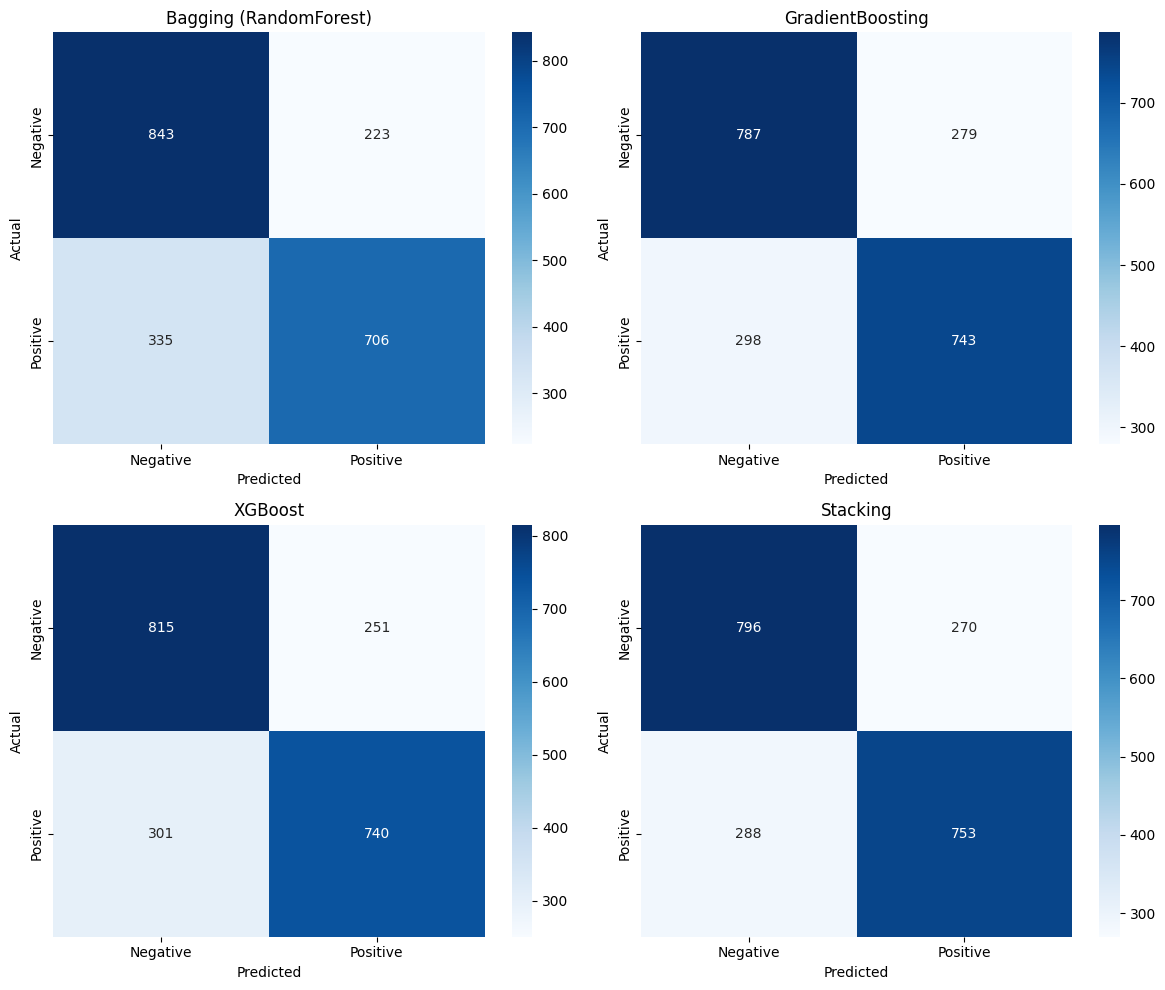

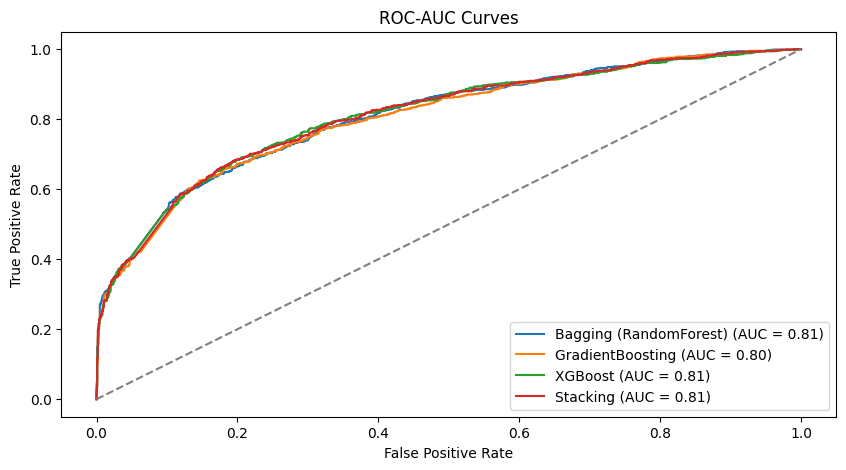

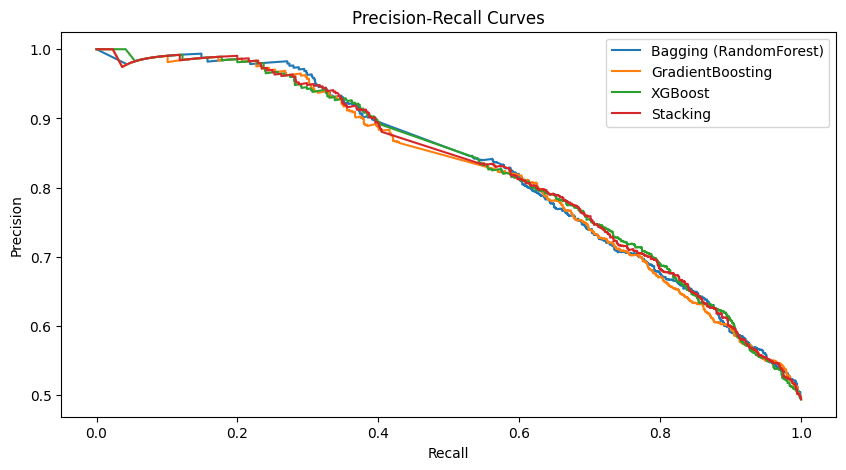

🔹 Bagging (RandomForest) Metrics:
              precision    recall  f1-score      support
0              0.715620  0.790807  0.751337  1066.000000
1              0.759957  0.678194  0.716751  1041.000000
accuracy       0.735168  0.735168  0.735168     0.735168
macro avg      0.737788  0.734500  0.734044  2107.000000
weighted avg   0.737525  0.735168  0.734249  2107.000000


🔹 GradientBoosting Metrics:
              precision    recall  f1-score      support
0              0.725346  0.738274  0.731753  1066.000000
1              0.727006  0.713737  0.720310  1041.000000
accuracy       0.726151  0.726151  0.726151     0.726151
macro avg      0.726176  0.726005  0.726031  2107.000000
weighted avg   0.726166  0.726151  0.726099  2107.000000


🔹 XGBoost Metrics:
              precision    recall  f1-score      support
0              0.730287  0.764540  0.747021  1066.000000
1              0.746720  0.710855  0.728346  1041.000000
accuracy       0.738016  0.738016  0.738016     0.738016
mac

In [66]:
# ============================== METRICS & PLOTS ===================================

models = {
    "Bagging (RandomForest)": best_rf,
    "GradientBoosting": best_gb,
    "XGBoost": best_xgb,
    "Stacking": stacking_model
}

# Store metrics
metrics_results = {}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    
    # Save metrics
    metrics_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    
    # Plot Confusion Matrix
    cm = metrics_results[name]["confusion_matrix"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ============================== ROC-AUC & PRECISION-RECALL CURVES ===================================

plt.figure(figsize=(10, 5))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 5))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

# ============================== DISPLAY CLASSIFICATION REPORTS ===================================

for name, metrics in metrics_results.items():
    print(f"🔹 {name} Metrics:")
    print(pd.DataFrame(metrics["classification_report"]).T)
    print("\n")

# ============================== BEST HYPERPARAMETERS ===================================

print("\n🔹 Best Hyperparameters:")
print("Random Forest:", rf_grid.best_params_)
print("Gradient Boosting:", gb_grid.best_params_)
print("XGBoost:", xgb_grid.best_params_)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [68]:
# Convert labels to categorical (one-hot encoding)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])  # Convert 'positive' -> 1, 'negative' -> 0
y = to_categorical(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Tensor format
X_train = np.array(X_train)
X_test = np.array(X_test)

print("Shape of X_train:", X_train.shape)  # Should be (num_samples, vector_size)
print("Shape of y_train:", y_train.shape)  # Should be (num_samples, num_classes)


Shape of X_train: (8425, 100)
Shape of y_train: (8425, 2)


In [69]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='relu', return_sequences=False, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Output layer (2 classes)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


In [70]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=False, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Output layer (2 classes)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


In [71]:
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, activation='tanh', return_sequences=False), input_shape=input_shape),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Output layer (2 classes)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


In [73]:
input_shape = (X_train.shape[1], 1)  # Reshape input for RNN/LSTM/BiLSTM

# Reshape X_train and X_test for RNNs
X_train_rnn = np.expand_dims(X_train, axis=-1)
X_test_rnn = np.expand_dims(X_test, axis=-1)

# Train RNN
rnn_model = build_rnn_model(input_shape)
rnn_model.fit(X_train_rnn, y_train, validation_data=(X_test_rnn, y_test), epochs=5, batch_size=32)

# Train LSTM
lstm_model = build_lstm_model(input_shape)
lstm_model.fit(X_train_rnn, y_train, validation_data=(X_test_rnn, y_test), epochs=5, batch_size=32)

# Train BiLSTM
bilstm_model = build_bilstm_model(input_shape)
bilstm_model.fit(X_train_rnn, y_train, validation_data=(X_test_rnn, y_test), epochs=5, batch_size=32)


Epoch 1/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6459 - loss: 0.6445 - val_accuracy: 0.7257 - val_loss: 0.5537
Epoch 2/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7209 - loss: 0.5642 - val_accuracy: 0.7167 - val_loss: 0.5568
Epoch 3/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7275 - loss: 0.5622 - val_accuracy: 0.7276 - val_loss: 0.5556
Epoch 4/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7268 - loss: 0.5663 - val_accuracy: 0.7280 - val_loss: 0.5494
Epoch 5/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7270 - loss: 0.5558 - val_accuracy: 0.7290 - val_loss: 0.5522
Epoch 1/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5631 - loss: 0.6745 - val_accuracy: 0.7086 - val_loss: 0.5841
Epoch 2/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6938 - loss: 0.5918 - val_accuracy: 0.7271 - val_loss: 0.5625
Epoch 3/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7115 - loss: 0.5836 - val_accuracy: 0.715

In [74]:
# Evaluate RNN
rnn_loss, rnn_acc = rnn_model.evaluate(X_test_rnn, y_test)
print(f"RNN Accuracy: {rnn_acc:.4f}")

# Evaluate LSTM
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_rnn, y_test)
print(f"LSTM Accuracy: {lstm_acc:.4f}")

# Evaluate BiLSTM
bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test_rnn, y_test)
print(f"BiLSTM Accuracy: {bilstm_acc:.4f}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - loss: 0.5532
RNN Accuracy: 0.7290
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7212 - loss: 0.5552
LSTM Accuracy: 0.7266
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7399 - loss: 0.5530
BiLSTM Accuracy: 0.7295


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


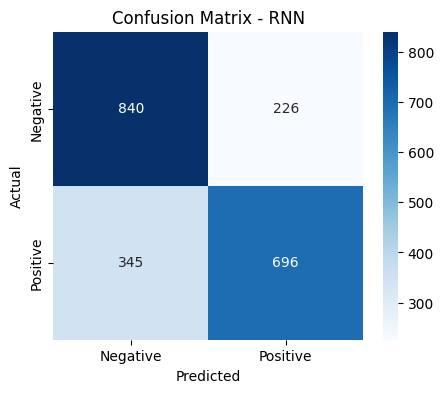

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


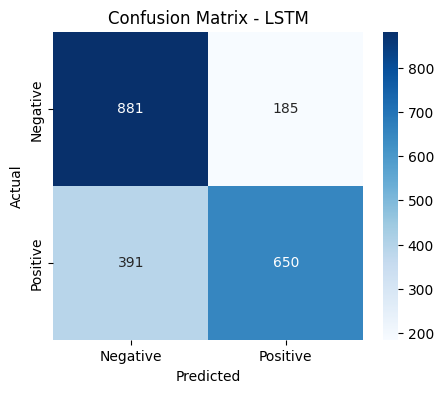

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


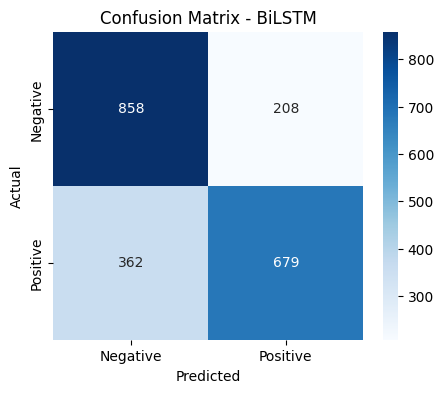

In [77]:
from sklearn.metrics import confusion_matrix

for name, model in models.items():
    y_pred = model.predict(X_test_rnn)
    y_pred_class = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_class)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


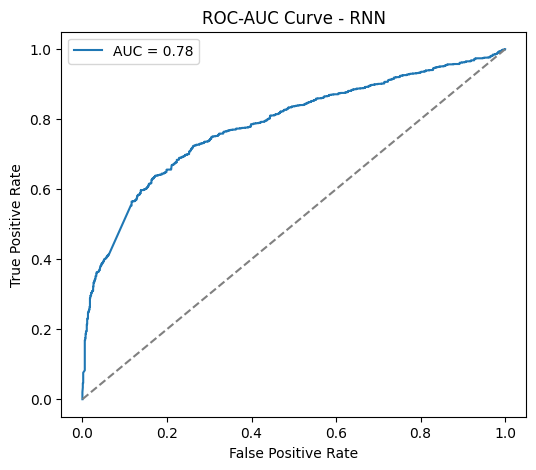

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


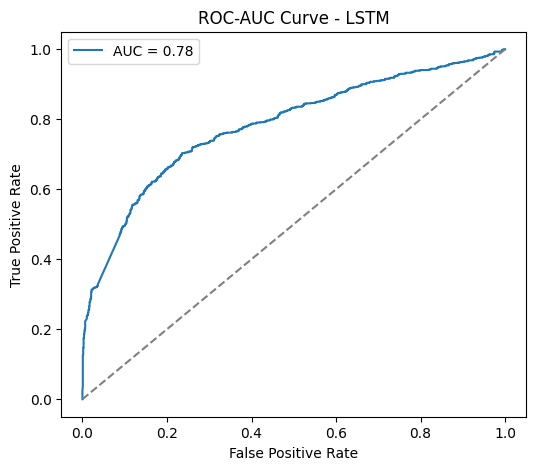

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


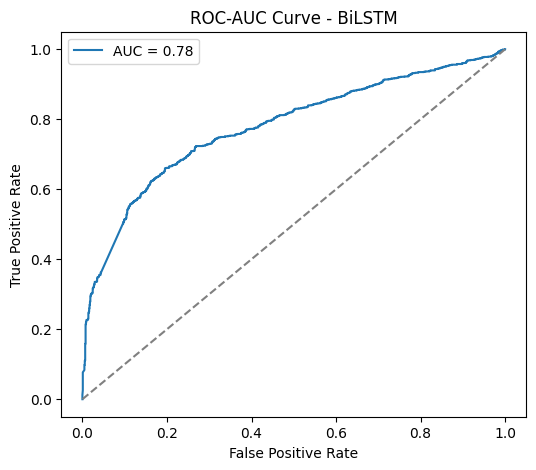

In [78]:
from sklearn.metrics import roc_curve, auc

for name, model in models.items():
    y_pred = model.predict(X_test_rnn)
    
    fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])  # Assumes one-hot encoding

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-AUC Curve - {name}")
    plt.legend()
    plt.show()


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


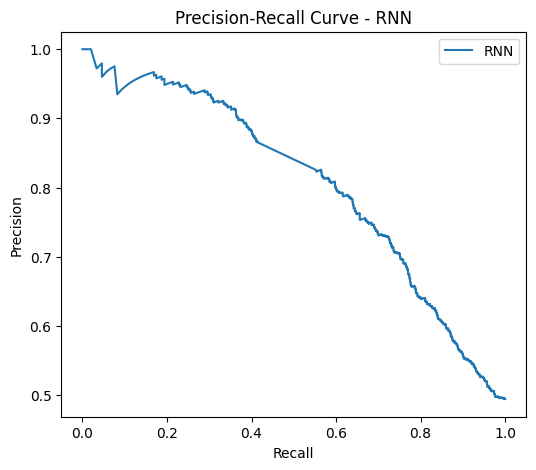

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


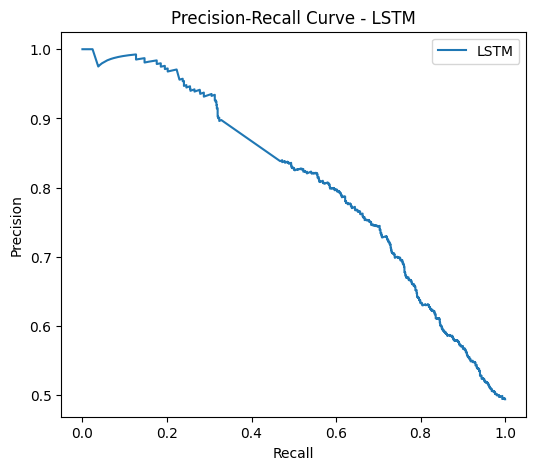

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


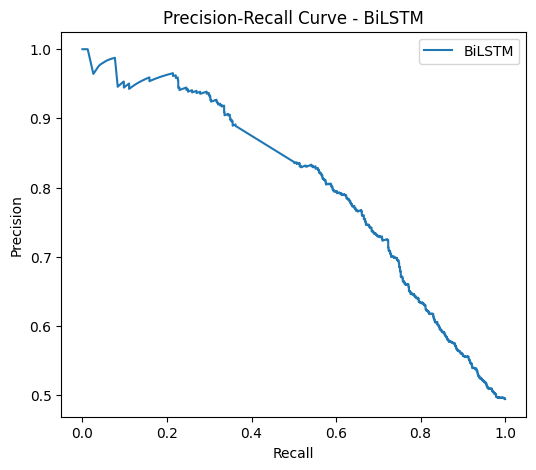

In [79]:
from sklearn.metrics import precision_recall_curve

for name, model in models.items():
    y_pred = model.predict(X_test_rnn)
    
    precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred[:, 1])

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.show()


In [81]:
from sklearn.metrics import accuracy_score
import numpy as np

# Convert ensemble model predictions to binary
y_test_binary = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to binary

accuracy_scores = {
    "RandomForest": accuracy_score(y_test_binary, best_rf.predict(X_test)),
    "GradientBoosting": accuracy_score(y_test_binary, best_gb.predict(X_test)),
    "XGBoost": accuracy_score(y_test_binary, best_xgb.predict(X_test)),
    "Stacking": accuracy_score(y_test_binary, stacking_model.predict(X_test)),

    # Convert deep learning model outputs
    "RNN": accuracy_score(y_test_binary, np.argmax(rnn_model.predict(X_test_rnn), axis=1)),
    "LSTM": accuracy_score(y_test_binary, np.argmax(lstm_model.predict(X_test_rnn), axis=1)),
    "BiLSTM": accuracy_score(y_test_binary, np.argmax(bilstm_model.predict(X_test_rnn), axis=1)),
}


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


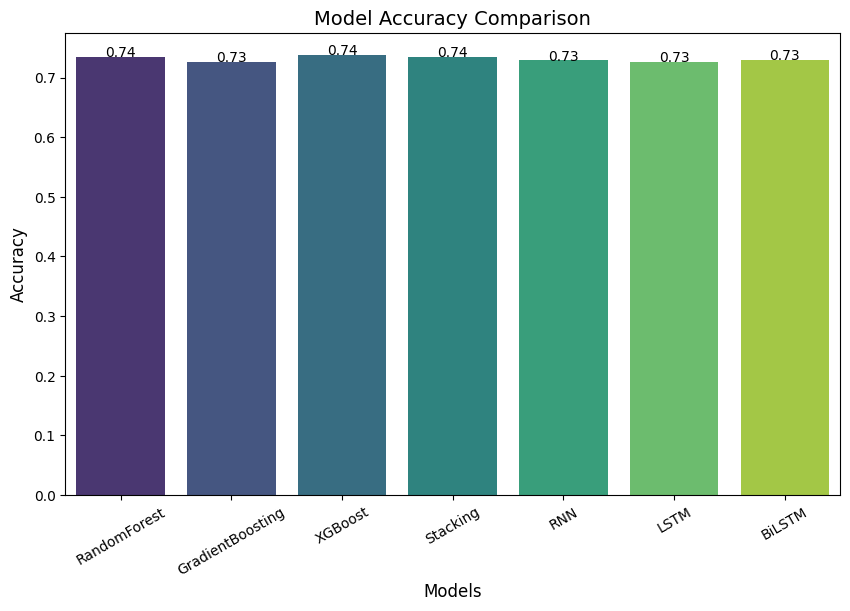

In [83]:
import seaborn as sns
import pandas as pd
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=["Model", "Accuracy"])

# Seaborn Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette="viridis")

# Add labels
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xticks(rotation=30)  # Rotate x-axis labels for readability

# Show values on top of bars
for index, row in accuracy_df.iterrows():
    plt.text(index, row["Accuracy"], f"{row['Accuracy']:.2f}", ha="center", fontsize=10)

plt.show()

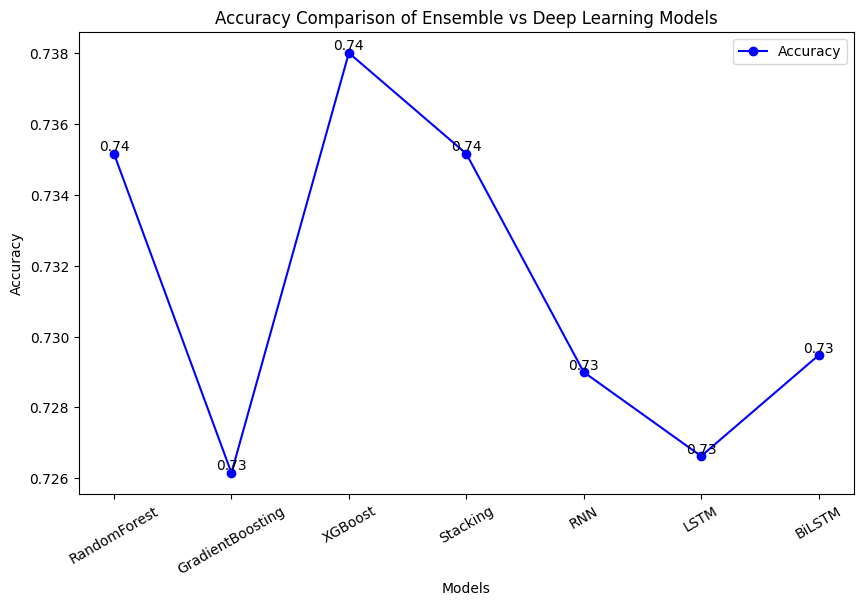

In [84]:
# Convert dictionary to sorted list (for consistent plotting)
models = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker="o", linestyle="-", color="b", label="Accuracy")

for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha="center", va="bottom", fontsize=10)

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Ensemble vs Deep Learning Models")
plt.xticks(rotation=30)
plt.legend()
plt.show()